In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [14]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 10])


In [15]:
train_df = pd.read_csv("/content/gdrive/MyDrive/digit-recognizer/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/digit-recognizer/test.csv")
submission_df = pd.read_csv("/content/gdrive/MyDrive/digit-recognizer/sample_submission.csv")

In [16]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [17]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

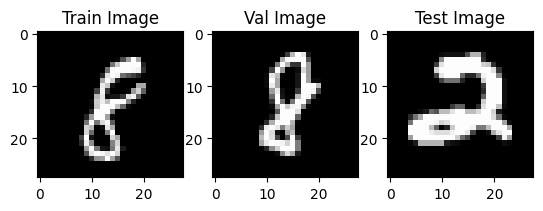

In [18]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [19]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00, 10.69it/s]


------------------------------
Train Loss EPOCH 1: 2.2314
Valid Loss EPOCH 1: 1.9547


  2%|▎         | 1/40 [00:24<15:46, 24.28s/it]

Train Accuracy EPOCH 1: 0.1514
Valid Accuracy EPOCH 1: 0.2457
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


------------------------------
Train Loss EPOCH 2: 1.7871
Valid Loss EPOCH 2: 1.5756


  5%|▌         | 2/40 [00:49<15:39, 24.73s/it]

Train Accuracy EPOCH 2: 0.3859
Valid Accuracy EPOCH 2: 0.5126
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


------------------------------
Train Loss EPOCH 3: 1.4942
Valid Loss EPOCH 3: 1.2989


  8%|▊         | 3/40 [01:12<14:57, 24.24s/it]

Train Accuracy EPOCH 3: 0.5515
Valid Accuracy EPOCH 3: 0.6545
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.72it/s]


------------------------------
Train Loss EPOCH 4: 1.3335
Valid Loss EPOCH 4: 1.1940


 10%|█         | 4/40 [01:36<14:27, 24.10s/it]

Train Accuracy EPOCH 4: 0.6294
Valid Accuracy EPOCH 4: 0.6902
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


------------------------------
Train Loss EPOCH 5: 1.2314
Valid Loss EPOCH 5: 1.1343


 12%|█▎        | 5/40 [02:00<14:03, 24.10s/it]

Train Accuracy EPOCH 5: 0.6679
Valid Accuracy EPOCH 5: 0.7167
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.62it/s]


------------------------------
Train Loss EPOCH 6: 1.1548
Valid Loss EPOCH 6: 1.0383


 15%|█▌        | 6/40 [02:22<13:15, 23.39s/it]

Train Accuracy EPOCH 6: 0.6936
Valid Accuracy EPOCH 6: 0.7367
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.32it/s]


------------------------------
Train Loss EPOCH 7: 1.0824
Valid Loss EPOCH 7: 0.9794


 18%|█▊        | 7/40 [02:46<12:50, 23.35s/it]

Train Accuracy EPOCH 7: 0.7179
Valid Accuracy EPOCH 7: 0.7583
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.89it/s]


------------------------------
Train Loss EPOCH 8: 1.0171
Valid Loss EPOCH 8: 0.9457


 20%|██        | 8/40 [03:09<12:27, 23.36s/it]

Train Accuracy EPOCH 8: 0.7386
Valid Accuracy EPOCH 8: 0.7669
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.02it/s]


------------------------------
Train Loss EPOCH 9: 0.9541
Valid Loss EPOCH 9: 0.8351


 22%|██▎       | 9/40 [03:33<12:08, 23.52s/it]

Train Accuracy EPOCH 9: 0.7566
Valid Accuracy EPOCH 9: 0.8002
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


------------------------------
Train Loss EPOCH 10: 0.8999
Valid Loss EPOCH 10: 0.8081


 25%|██▌       | 10/40 [03:55<11:35, 23.19s/it]

Train Accuracy EPOCH 10: 0.7711
Valid Accuracy EPOCH 10: 0.8036
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.16it/s]


------------------------------
Train Loss EPOCH 11: 0.8543
Valid Loss EPOCH 11: 0.7417


 28%|██▊       | 11/40 [04:21<11:33, 23.92s/it]

Train Accuracy EPOCH 11: 0.7842
Valid Accuracy EPOCH 11: 0.8248
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


------------------------------
Train Loss EPOCH 12: 0.8151
Valid Loss EPOCH 12: 0.7114


 30%|███       | 12/40 [04:44<11:04, 23.75s/it]

Train Accuracy EPOCH 12: 0.7924
Valid Accuracy EPOCH 12: 0.8338
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.01it/s]


------------------------------
Train Loss EPOCH 13: 0.7632
Valid Loss EPOCH 13: 0.6639


 32%|███▎      | 13/40 [05:07<10:30, 23.33s/it]

Train Accuracy EPOCH 13: 0.8057
Valid Accuracy EPOCH 13: 0.8426
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


------------------------------
Train Loss EPOCH 14: 0.7152
Valid Loss EPOCH 14: 0.6131


 35%|███▌      | 14/40 [05:30<10:08, 23.40s/it]

Train Accuracy EPOCH 14: 0.8197
Valid Accuracy EPOCH 14: 0.8598
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


------------------------------
Train Loss EPOCH 15: 0.6754
Valid Loss EPOCH 15: 0.5643


 38%|███▊      | 15/40 [05:53<09:39, 23.18s/it]

Train Accuracy EPOCH 15: 0.8313
Valid Accuracy EPOCH 15: 0.8733
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.13it/s]


------------------------------
Train Loss EPOCH 16: 0.6413
Valid Loss EPOCH 16: 0.5454


 40%|████      | 16/40 [06:17<09:21, 23.42s/it]

Train Accuracy EPOCH 16: 0.8390
Valid Accuracy EPOCH 16: 0.8731
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


------------------------------
Train Loss EPOCH 17: 0.6214
Valid Loss EPOCH 17: 0.5210


 42%|████▎     | 17/40 [06:39<08:49, 23.01s/it]

Train Accuracy EPOCH 17: 0.8423
Valid Accuracy EPOCH 17: 0.8779
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.32it/s]


------------------------------
Train Loss EPOCH 18: 0.5864
Valid Loss EPOCH 18: 0.5075


 45%|████▌     | 18/40 [07:02<08:28, 23.10s/it]

Train Accuracy EPOCH 18: 0.8506
Valid Accuracy EPOCH 18: 0.8824
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.69it/s]


------------------------------
Train Loss EPOCH 19: 0.5631
Valid Loss EPOCH 19: 0.4698


 48%|████▊     | 19/40 [07:25<08:01, 22.92s/it]

Train Accuracy EPOCH 19: 0.8546
Valid Accuracy EPOCH 19: 0.8900
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.02it/s]


------------------------------
Train Loss EPOCH 20: 0.5388
Valid Loss EPOCH 20: 0.4668


 50%|█████     | 20/40 [07:48<07:39, 22.99s/it]

Train Accuracy EPOCH 20: 0.8599
Valid Accuracy EPOCH 20: 0.8876
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


------------------------------
Train Loss EPOCH 21: 0.5077
Valid Loss EPOCH 21: 0.4360


 52%|█████▎    | 21/40 [08:11<07:14, 22.87s/it]

Train Accuracy EPOCH 21: 0.8692
Valid Accuracy EPOCH 21: 0.8948
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.12it/s]


------------------------------
Train Loss EPOCH 22: 0.4905
Valid Loss EPOCH 22: 0.4075


 55%|█████▌    | 22/40 [08:34<06:52, 22.93s/it]

Train Accuracy EPOCH 22: 0.8729
Valid Accuracy EPOCH 22: 0.8995
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.77it/s]


------------------------------
Train Loss EPOCH 23: 0.4690
Valid Loss EPOCH 23: 0.4259


 57%|█████▊    | 23/40 [08:56<06:29, 22.89s/it]

Train Accuracy EPOCH 23: 0.8772
Valid Accuracy EPOCH 23: 0.8981
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.06it/s]


------------------------------
Train Loss EPOCH 24: 0.4524
Valid Loss EPOCH 24: 0.3596


 60%|██████    | 24/40 [09:19<06:05, 22.87s/it]

Train Accuracy EPOCH 24: 0.8809
Valid Accuracy EPOCH 24: 0.9079
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


------------------------------
Train Loss EPOCH 25: 0.4409
Valid Loss EPOCH 25: 0.3705


 62%|██████▎   | 25/40 [09:43<05:45, 23.03s/it]

Train Accuracy EPOCH 25: 0.8814
Valid Accuracy EPOCH 25: 0.9060
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.43it/s]


------------------------------
Train Loss EPOCH 26: 0.4140
Valid Loss EPOCH 26: 0.3662


 65%|██████▌   | 26/40 [10:05<05:19, 22.80s/it]

Train Accuracy EPOCH 26: 0.8892
Valid Accuracy EPOCH 26: 0.9069
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


------------------------------
Train Loss EPOCH 27: 0.4007
Valid Loss EPOCH 27: 0.3596


 68%|██████▊   | 27/40 [10:28<04:58, 22.95s/it]

Train Accuracy EPOCH 27: 0.8932
Valid Accuracy EPOCH 27: 0.9090
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.35it/s]


------------------------------
Train Loss EPOCH 28: 0.3871
Valid Loss EPOCH 28: 0.3083


 70%|███████   | 28/40 [10:51<04:33, 22.75s/it]

Train Accuracy EPOCH 28: 0.8955
Valid Accuracy EPOCH 28: 0.9224
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


------------------------------
Train Loss EPOCH 29: 0.3784
Valid Loss EPOCH 29: 0.2941


 72%|███████▎  | 29/40 [11:14<04:11, 22.89s/it]

Train Accuracy EPOCH 29: 0.8970
Valid Accuracy EPOCH 29: 0.9267
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.42it/s]


------------------------------
Train Loss EPOCH 30: 0.3625
Valid Loss EPOCH 30: 0.3043


 75%|███████▌  | 30/40 [11:36<03:47, 22.77s/it]

Train Accuracy EPOCH 30: 0.9033
Valid Accuracy EPOCH 30: 0.9264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.31it/s]


------------------------------
Train Loss EPOCH 31: 0.3549
Valid Loss EPOCH 31: 0.3033


 78%|███████▊  | 31/40 [11:59<03:26, 22.91s/it]

Train Accuracy EPOCH 31: 0.9028
Valid Accuracy EPOCH 31: 0.9205
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


------------------------------
Train Loss EPOCH 32: 0.3411
Valid Loss EPOCH 32: 0.2818


 80%|████████  | 32/40 [12:22<03:01, 22.74s/it]

Train Accuracy EPOCH 32: 0.9067
Valid Accuracy EPOCH 32: 0.9257
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.54it/s]


------------------------------
Train Loss EPOCH 33: 0.3292
Valid Loss EPOCH 33: 0.2621


 82%|████████▎ | 33/40 [12:45<02:39, 22.84s/it]

Train Accuracy EPOCH 33: 0.9094
Valid Accuracy EPOCH 33: 0.9281
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


------------------------------
Train Loss EPOCH 34: 0.3201
Valid Loss EPOCH 34: 0.2715


 85%|████████▌ | 34/40 [13:09<02:19, 23.24s/it]

Train Accuracy EPOCH 34: 0.9121
Valid Accuracy EPOCH 34: 0.9267
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.44it/s]


------------------------------
Train Loss EPOCH 35: 0.3257
Valid Loss EPOCH 35: 0.2542


 88%|████████▊ | 35/40 [13:32<01:56, 23.22s/it]

Train Accuracy EPOCH 35: 0.9076
Valid Accuracy EPOCH 35: 0.9350
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


------------------------------
Train Loss EPOCH 36: 0.3157
Valid Loss EPOCH 36: 0.2433


 90%|█████████ | 36/40 [13:55<01:32, 23.20s/it]

Train Accuracy EPOCH 36: 0.9117
Valid Accuracy EPOCH 36: 0.9374
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.40it/s]


------------------------------
Train Loss EPOCH 37: 0.3009
Valid Loss EPOCH 37: 0.2289


 92%|█████████▎| 37/40 [14:18<01:09, 23.01s/it]

Train Accuracy EPOCH 37: 0.9154
Valid Accuracy EPOCH 37: 0.9369
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


------------------------------
Train Loss EPOCH 38: 0.2913
Valid Loss EPOCH 38: 0.2346


 95%|█████████▌| 38/40 [14:41<00:46, 23.07s/it]

Train Accuracy EPOCH 38: 0.9179
Valid Accuracy EPOCH 38: 0.9352
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


------------------------------
Train Loss EPOCH 39: 0.2889
Valid Loss EPOCH 39: 0.2558


 98%|█████████▊| 39/40 [15:03<00:22, 22.84s/it]

Train Accuracy EPOCH 39: 0.9185
Valid Accuracy EPOCH 39: 0.9267
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.71it/s]


------------------------------
Train Loss EPOCH 40: 0.2820
Valid Loss EPOCH 40: 0.2242


100%|██████████| 40/40 [15:27<00:00, 23.18s/it]

Train Accuracy EPOCH 40: 0.9199
Valid Accuracy EPOCH 40: 0.9402
------------------------------
Training Time: 927.06s


In [21]:
torch.cuda.empty_cache()

In [22]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00, 10.21it/s]


<Figure size 640x480 with 0 Axes>

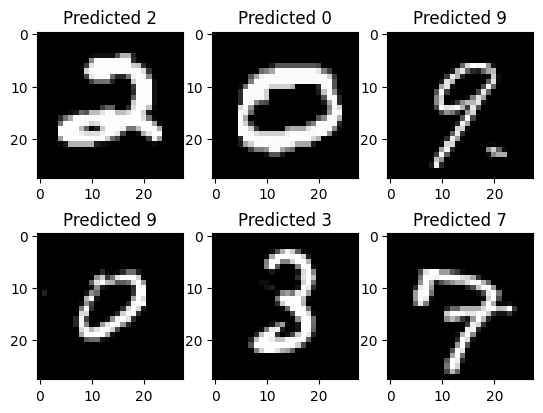

In [23]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [24]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
